# Autonomy fleet visualization

The objectives of this notebook are to :
<ol>
    <li> Download autonomy assets data </li>
    <li> Show the current location of autonomy assets </li>
    <li> Show the last profiles of the assets </li>
    <li> Show the full depth/time transect of the assets </li>
</ol>

To run this notebook please refer to the readme of the github page (https://github.com/NOC-OBG-Autonomy/biocarbon_nrt_data_viz).

## Download autonomy assets data

In [20]:
import pandas as pd
import requests
import shutil
import os
import gzip
from pathlib import Path
import re
from tqdm import tqdm
from urllib.request import urlretrieve
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

We build the data repository structure. The data folder is not sync with git, so we need to create it if missing (i.e. first time your run this notebook on your computer).

In [3]:
def create_missing_directories():
    # Define the path to the parent directory
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

    # Check if 'data' folder exists in the parent directory
    data_dir = os.path.join(parent_dir, 'data')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print("'data' folder created in the parent directory.")
    else:
        print("'data' folder already exists in the parent directory.")

    # Check if 'floats' directory exists inside 'data' folder
    floats_dir = os.path.join(data_dir, 'Floats')
    if not os.path.exists(floats_dir):
        os.makedirs(floats_dir)
        print("'floats' directory created inside 'data' folder.")
    else:
        print("'floats' directory already exists inside 'data' folder.")

    # Check if 'gliders' directory exists inside 'data' folder
    gliders_dir = os.path.join(data_dir, 'Gliders')
    if not os.path.exists(gliders_dir):
        os.makedirs(gliders_dir)
        print("'gliders' directory created inside 'data' folder.")
    else:
        print("'gliders' directory already exists inside 'data' folder.")

if __name__ == "__main__":
    create_missing_directories()

'data' folder already exists in the parent directory.
'floats' directory already exists inside 'data' folder.
'gliders' directory already exists inside 'data' folder.


For now, we will visualize only test floats. One in the Icelandic bassin and the other in SO during the Custard cruise, which is a good test case as it has also gliders deployements.

We don't automate in this script the retrieving of downloading url for the sake of simplicity. 
You can keep in mind that the list of float data and their repertory are findable here : https://data-argo.ifremer.fr/argo_synthetic-profile_index.tx

In [5]:
wmo_list = [4903532, 5906213]
#Float 1 = test float in the Icelandic Bassin
float_1_url = 'https://data-argo.ifremer.fr/dac/aoml/4903532/4903532_Sprof.nc'
#Float 2 = test float on Custard with glider next to it
float_2_url = 'https://data-argo.ifremer.fr/dac/aoml/5906213/5906213_Sprof.nc'

#List the floats
floats_url = [float_1_url, float_2_url]

#Assign the local float directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
floats_dir =  os.path.join(parent_dir, 'Data/Floats')

#Create floats filename
floats_filenames = []
for i in floats_url:
    filename = floats_dir + '/' + i.rsplit('/', 1)[1]
    floats_filenames.append(filename)

In [6]:
#Download floats data. We do it everytime so we are sure to work with a DAC up to date version. 
#We could check with the synthetic profile index if it is needed to download a update.
for url, filename in zip(floats_url, floats_filenames):
    urlretrieve(url, filename)


## Plot BGC-Argo locations

### Icelandic Basin float

In [7]:
print(wmo_list)

[4903532, 5906213]


In [16]:
position_df = pd.DataFrame({'PROF_NUM' : str(), 'LONGITUDE' : [], 'LATITUDE' : [], 'float' : int()})
for file, wmo in zip(floats_filenames, wmo_list):
    dat = xr.open_dataset(file)
    dat = dat.rename({'CYCLE_NUMBER':'PROF_NUM'}).swap_dims({'N_PROF':'PROF_NUM'})
    temp_df = dat[['LONGITUDE', 'LATITUDE']].to_dataframe().reset_index()
    temp_df['float'] = wmo
    position_df = pd.concat([position_df, temp_df], ignore_index=True)
    dat.close()
    

C:\Users\flapet\AppData\Local\Temp\ipykernel_26536\1381283814.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  position_df = pd.concat([position_df, temp_df], ignore_index=True)


In [22]:
# load the low resolution world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

C:\Users\flapet\AppData\Local\Temp\ipykernel_26536\3359036695.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


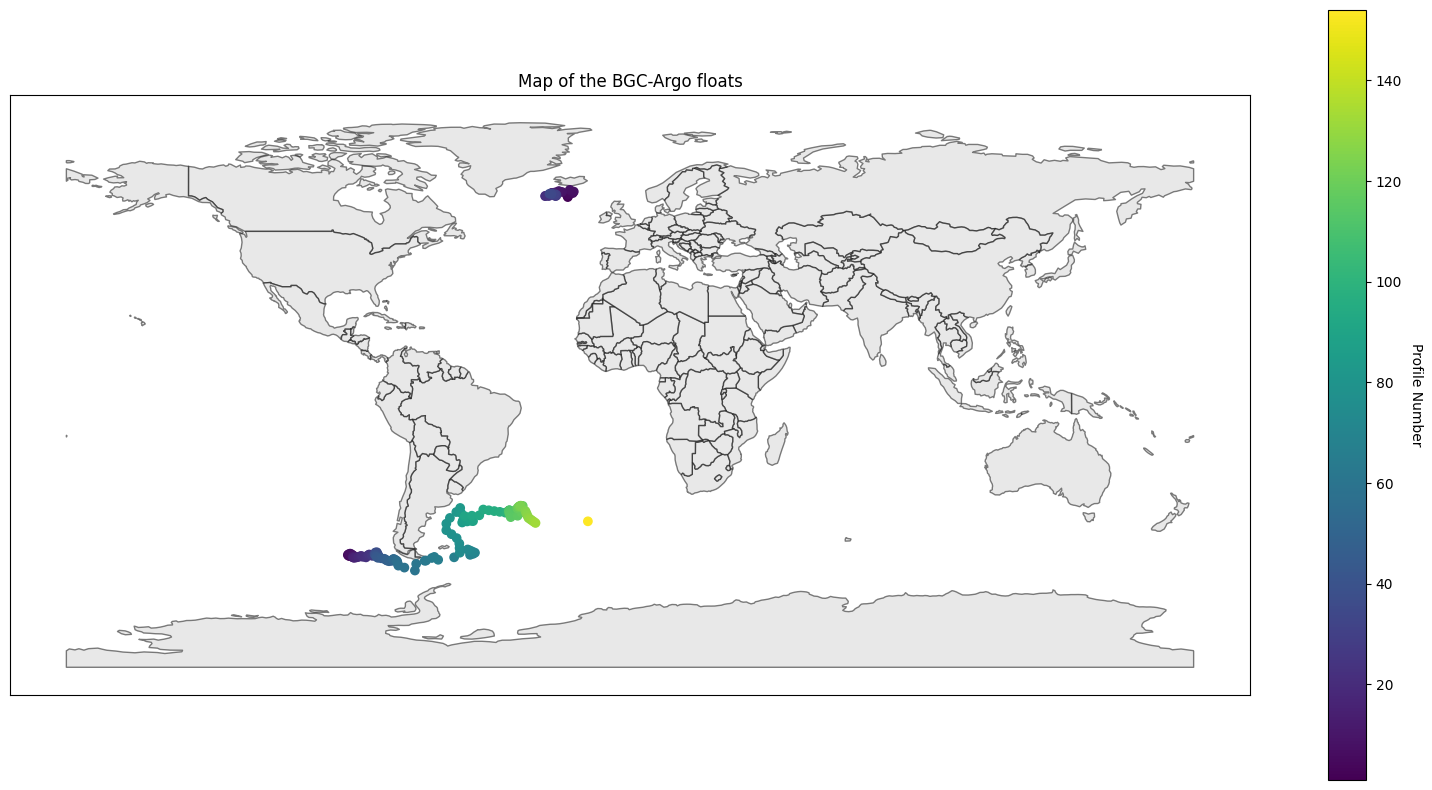

In [29]:
# initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

plt.scatter(position_df['LONGITUDE'], position_df['LATITUDE'], c = position_df['PROF_NUM'])

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

#set the plot color bar
cbar = plt.colorbar(label='Profile Number')
cbar.set_label('Profile Number', rotation=270, labelpad=15)

# set the plot title
plt.title("Map of the BGC-Argo floats")
plt.show()